#### Lecture 1: Understanding financial data

#### Price data


Price data is determined by two charactereistics, frequency of data and types of data. Frequency of data can ranged from microseconds data (tick level) to end-of-date data (daily resolution). We will focus on data that have a minute resoluion or above. Major types of data include bar data, trade data and quote data.

In an exchange, quote data (Orderbook) is displayed for a stock in real time which has the bid and ask price (with size) submitted by different market participants. Market makers are responsible for providing liquidity to different traded assets, by placing quotes continuously. A trade is made if someone is willing the buy the security at the ask price (or sell the security at the bid price). Trade data is simply a collection of all the trades of a stock made at different exchanges, along with delayed data reported from dark pools. Bar data is then aggregrated using the trade price and volume over an interval, which usually is a minute, an hour and a day.

https://iextrading.com/apps/tops/

A typical bar data would consists of 5 data fields: Open, High, Low, Close and Volume (OHLCV). For free data sources you can found online, volume data will often has the most discrepencies as off-exchange trades are often ignored/miscounted. 

The construction and processing of market data feeds invovles a lot of technical knowledge that is essential for market makers and quants reponsible for trade execution, but not too important for long-term investors. 

We will first illustrate some basic concepts in finance using the most famous ETF, SPDR S&P 500 (SPY) which keep tracks of the most important stock market index S&P 500 in the world. This ETF invest in the 500 biggest stocks listed in the US, weighted by market-cap. (The exact rules to construct S&P 500 index is more complicated than this) 

In [2]:
! pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=828c697ef307d31d149492859c435426e20c9bc11d50b6df41078799acc21cea
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")

As stocks can pay dividend and have splits, we usually use adjusted price to perform statistical analysis. From the adjusted price, we can derive the total return of the stock (which is the sum of price return and dividends, reinvested). 

Always check whether dividend and splits are adjusted before running your models. 

Here I provide two examples of why data management is important and how listed companies can use that as their own advantage. 

- Example 1: Tesla stock splits         
A stock split in theory do not change the underlying value of the company, but for retail investors looking at the price at their apps, it does look cheaper, so people buy more. 

- Example 2: Ticker name change        
GSX Techedu (GOTU) changes its ticker from GSX even without any major changes such as M&A or corporate restructuring. For retail investors, it appears as new stock for them. It also distances itself from the negative press as Muddy Waters and others are holding a short position against them.  Search engine results for GSX and GOTU are different. It seems to me like a form of SEO. 
After the name change, some of the free apps that most retail traders use to keep track of stock prices cannot recognise this change and return incomplete historical data. 



In [ ]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-28,439.690002,440.040009,432.940002,433.720001,130436300,0.0,0
2021-09-29,435.190002,437.040009,433.850006,434.450012,82329200,0.0,0
2021-09-30,436.019989,436.769989,428.779999,429.140015,140181200,0.0,0
2021-10-01,430.980011,436.029999,427.230011,434.239990,129240100,0.0,0
2021-10-04,433.000000,433.959991,426.359985,428.640015,128430500,0.0,0


Stock price are not stationary as they tend to grow over time. (Exception: Japanese stock market). 

For building models, it is better to use the log-return instead. Log-return is better than percentage return since it is additive over different time periods. 

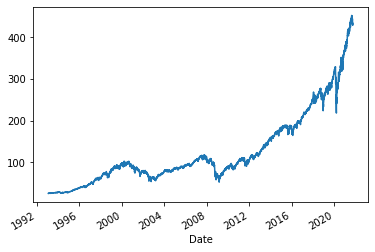

In [ ]:
hist['Close'].plot()

In [ ]:
## Calculating log-returns
hist['log_return'] = np.log(hist['Close']) - np.log(hist['Close'].shift(1))

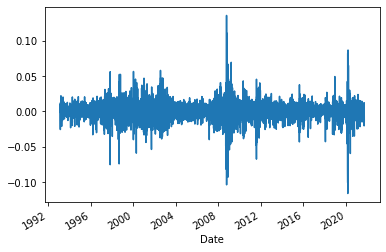

In [ ]:
hist['log_return'].plot()

#### Statistical properties of stock market log-returns 

- It has a positive mean, which is bigger than the average 10-year Treasury yield. This is called the risk premium of equity market

- It has a negative skew, which demonstrates the fact the stock market experiences sharp drawdowns over a short period (2008,2020) 

- It has a kurtosis greater than 3, suggesting it is more fat-tail than a normal distribution. 

- The assumption of log-return following Gaussian distribution(Geometric Brownian Process) is the foundation of Black-Scholes Option pricing model. 

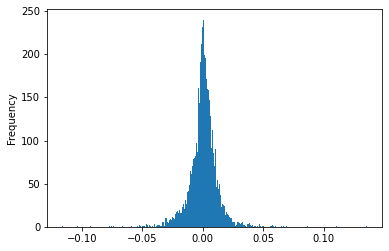

In [ ]:
hist['log_return'].plot.hist(bins=500)

In [ ]:
hist['log_return'].describe()

count    7222.000000
mean        0.000390
std         0.011825
min        -0.115886
25%        -0.004288
50%         0.000681
75%         0.005859
max         0.135578
Name: log_return, dtype: float64

In [ ]:
hist['log_return'].skew()

-0.2996344311157923

In [ ]:
hist['log_return'].kurtosis()

11.78171968286361

## How to analyse returns in stock market 

We can separate the return of stock market into two parts. One as the close-to-open return (overnight return) and open-to-close return (intraday return) 

We can see intraday return has a mean close to zero, suggesting the mean-reversion nature of stock price during market hours. 

Most of the stock market return, for a buy-and-hold strategy in the long run, comes from holding stocks overnight. This can be considered as compensation of the risk to hold stocks overnight. 

Holding stocks over the weekend and holiday will provide a similar risk premium. 


Calendar effects in stock market are often an artificat of human habits. Examples include stock return before and after the tax filing, end of month/quarter rebalancing of mutual funds, expiry of monthly and quarterly options. 


In [ ]:
hist['intraday_return'] = np.log(hist['Close']) - np.log(hist['Open'])
hist['overnight_return'] = np.log(hist['Open']) - np.log(hist['Close'].shift(1))

In [ ]:
hist['intraday_return'].describe()

count    7223.000000
mean       -0.000007
std         0.009651
min        -0.094207
25%        -0.004140
50%         0.000427
75%         0.004580
max         0.088892
Name: intraday_return, dtype: float64

In [ ]:
hist['overnight_return'].describe()

count    7222.000000
mean        0.000396
std         0.006729
min        -0.110357
25%        -0.002052
50%         0.000623
75%         0.003208
max         0.059519
Name: overnight_return, dtype: float64

## Volatility Scaling

We can measure the performance of a trading strategy by the sharpe ratio, which is ratio of excess return over to the volatility. 

Sharpe_Ratio = $\frac{r-r_f}{\sigma}$, where r is the return of the portfolio and $\sigma$ the standard deviation of the return of the portfolio. 

Volatility is detrimental to the long-term growth of capital as a strategy down 20% needs a 25% growth to recover. 

By adjusting our stock holdings so that portfolio is at a constant volatility, so that we buy more during low volatility times and buy less during high volatility times. The Sharpe ratio can be improved compared to a constant buy-and-hold strategy.

Volatility plays an important role in portfolio construction and risk management. Risk parity, a famous hedge fund strategy aims to hold constant volatility exposure to different assets in the portfolio, rather than equal weighted. 



In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

In [ ]:
# Weight portfolio by comparing the current 1-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

In [ ]:
hist['return'].mean() / hist['return'].std() * np.sqrt(252)

0.038933253086714165

In [ ]:
## Improvement of Sharpe ratio of constant vol strategy 
hist['vol_adj_return'].mean() / hist['vol_adj_return'].std() * np.sqrt(252)

0.05387732991872466

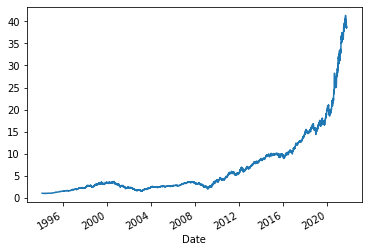

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

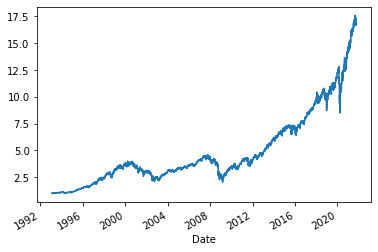

In [ ]:
(1+hist['return']).cumprod().plot()

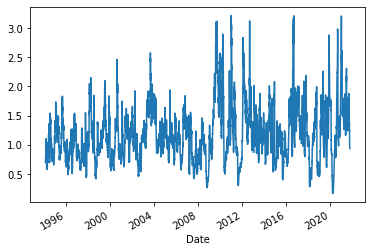

In [ ]:
hist['vol_port_size'].plot()

To carry out the above volatility adjusted strategy, you need to have access to leverage (up to 3x). 

In [ ]:
selected_etf = yf.Ticker("EEM")
hist = selected_etf.history(period="max")

In [ ]:
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

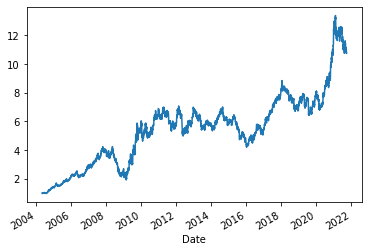

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

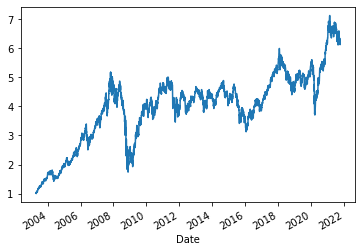

In [ ]:
(1+hist['return']).cumprod().plot()

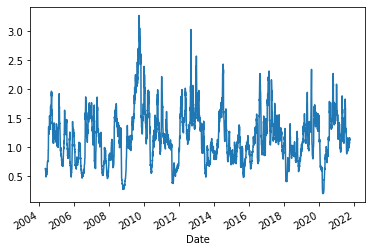

In [ ]:
hist['vol_port_size'].plot()

The above strategy also applies to EM stock market. As long as the ETF will generate positive return in the long run, volatility scaling can improve sharpe ratio and return of strategy. 


## Recommended readings 

- Algorithmic Trading: Winning Strategies and Their Rationale, Ernest P. Chan

- Advances in Financial Machine Learning, Marcos López de Prado

- A Complete Guide to the Futures Market: Technical Analysis, Trading Systems, Fundamental Analysis, Options, Spreads, and Trading Principles (Wiley Trading), Jack D. Schwager

## Lecture 2 Volatility 

Volatility is undesirable since they erode long term return of the portfolio. Investors are looking for ways to reduce portfolio volatility. For asset managers, holding government bonds and derivatives(put options) are common means to hedge against equity holdings they have.

A put option can be thought as an insurance policy in a informal way. From this perspective, asset managers buy put options (in reality put spreads or other more sophiscated strategies) to reduce drawdown in portfolio during market distress. 

The benefit of reducing drawdown and thus volatility in portfolio is that it allows rebalancing after market crash. Investors can sell their bonds or gains from put options to buy cheap stocks. 

In this lecture, we will show that the buy-and-hold strategy is inherent a short volatility strategy, which means it benefits when market volatility is low/falling. 


## Fear Gauge VIX 

VIX is considered as a fear gauge of global market. 

VIX is derived from the implied volatility of front-month options of SPX index. 

It is not possible to invest in VIX directly. There are volatility ETFs which keep tracks of the VIX Futures, where traders buy and sell to express their views on market volatility. VXX is an example of volatility ETF that are widely traded by retail.  

Due to rollover costs, VXX will generate a much worse return than VIX.

A crucial feature is that holding VIX futures, and similarly buying Put Options on SPY generates a negative return in the long run.

Considering the correlation between VXX (Long volatility) and SH (Short SPY) we conclude the long volatility strategies are inherently shorting the market. 

Assuming we can short VXX (that is short volatility) without additional borrowing cost, it will have a high correlation with the market return (long SPY). This is why we call buy-and-hold equity as inherenetly a short volatility strategy. 

Since buy-and-hold VXX will simply cancels the return from holding SPY, therefore VXX alone is not a good portfolio hedge. 




In [ ]:
## VIX index, the fear gauge of the global equity market 
selected_etf = yf.Ticker("^VIX")

In [ ]:
vixhist = selected_etf.history(period="max")

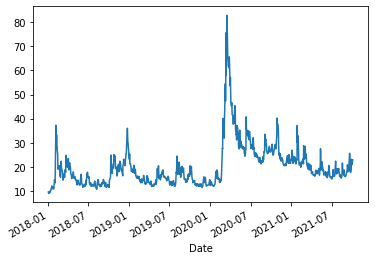

In [ ]:
vixhist['Close'].loc['2018-01-01':].plot()

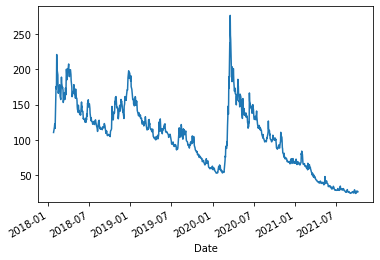

In [ ]:
selected_etf = yf.Ticker("VXX")
vxxhist = selected_etf.history(period="max")
vxxhist['Close'].loc['2018-01-01':].plot()

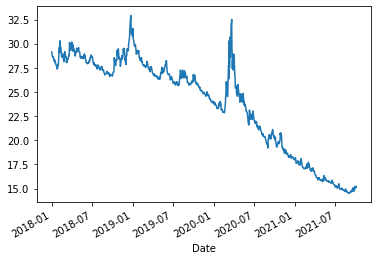

In [ ]:
selected_etf = yf.Ticker("SH")
shhist = selected_etf.history(period="max")
shhist['Close'].loc['2018-01-01':].plot()

In [ ]:
## Very high correlation between long volatility (UVXY) and short equity (SH) 
np.corrcoef(shhist['Close'].loc['2020-01-01':],vxxhist['Close'].loc['2020-01-01':])[0,1]

0.862606495929021

There are more than one kind of volatility ETFs

- VXX keep track of the S&P 500 VIX Short-Term Futures Index Total Return

- VXZ keep track of S&P 500 VIX Mid-Term Futures Index.

VXZ has a less significant contango effect than VXX, but keep track of the spot VIX less well. 

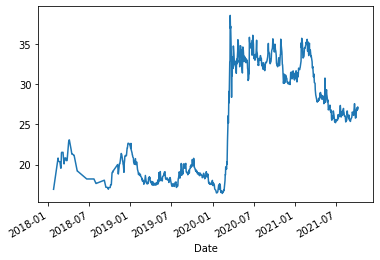

In [ ]:
selected_etf = yf.Ticker("VXZ")
vxzhist = selected_etf.history(period="max")
vxzhist['Close'].loc['2018-01-01':].plot()

In the following lectures we will introduce different strategy that aims to reduce portfolio drawdown during market drawdowns 

- Commodities Trend Following (Uncorrelated return during demand and supply shocks)
- Risk Parity (Leveraged bets on interest rates going down)
- Active Long Volatility (Time when to buy call/put options)



## Example of Market Regime model 

We will provide a very simple example of market regime model using Hidden Markov Model

In [ ]:
! pip install yfinance
! pip install hmmlearn

     |████████████████████████████████| 6.3 MB 31.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=d08a065c98d319cea879f6bc257d9d65be3f6204ad2cd1514d045bf0b3e0d4e3
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import numpy as np

selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")
spyhist['Return'] = spyhist['Open'].pct_change()
trainrets = spyhist.loc['1996-01-01':'2017-01-01']
testrets = spyhist.loc['2018-01-01':'2022-02-25']

In [ ]:
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].values.reshape(-1, 1))


In [ ]:

testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


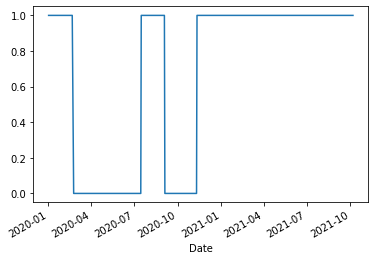

In [ ]:
testrets['State'].loc['2020-01-01':].plot()

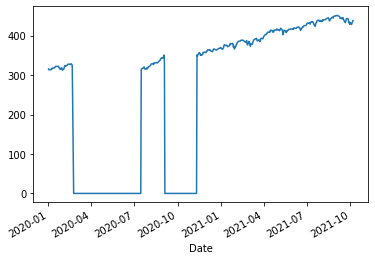

In [ ]:
testrets['Filtered'].loc['2020-01-01':].plot()

In [ ]:
## State 0 is bear market  
## State 1 is bull market 
testrets.groupby('State').mean()['Return']

State
0   -0.000540
1    0.001014
Name: Return, dtype: float64

In [ ]:
testrets.groupby('State').std()['Return']

State
0    0.021660
1    0.007312
Name: Return, dtype: float64

Can we obtain a similar model by cosidering the value of VIX? 

In [ ]:
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
selected_etf = yf.Ticker("^VIX")
vixhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
spyhist['Return'] = spyhist['Close'].pct_change()
spyhist['VIX'] = vixhist['Close']
spyhist['VIX_State'] = np.where(spyhist['VIX']<25,1,0)
trainrets = spyhist.loc['1996-01-01':'2015-01-01']
testrets = spyhist.loc['2018-01-01':'2022-01-01']

In [ ]:
testrets.groupby('VIX_State').mean()['Return']

VIX_State
0   -0.001212
1    0.001148
Name: Return, dtype: float64

In [ ]:
testrets.groupby('VIX_State').std()['Return']

VIX_State
0    0.025344
1    0.007969
Name: Return, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


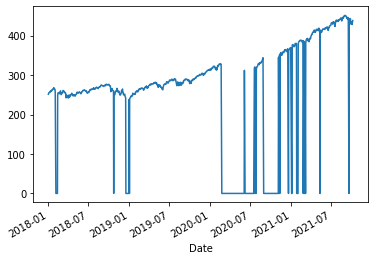

In [ ]:
testrets['Filtered'] = testrets['Close'] * testrets['VIX_State']
testrets['Filtered'].loc['2018-01-01':].plot()

Splitting the test period by the value of VIX provides a similar model as HMM. It suggests machine learning methods, applied on price data only might not outperform simple models based on econometrics. 



Changing the number of of hidden states in HMM model. The returns are clustered in three different states.

1. Low volatility states with positive return
2. Medium volatility states with near zero return
3. High volatility states with negative return 


In [ ]:
hmm_model = GaussianHMM(
        n_components=3, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].dropna().values.reshape(-1, 1))


In [ ]:
testrets = spyhist.loc['2018-01-01':'2021-12-25']
testrets['Shifted_Return'] = testrets['Return'].shift(-1)
testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

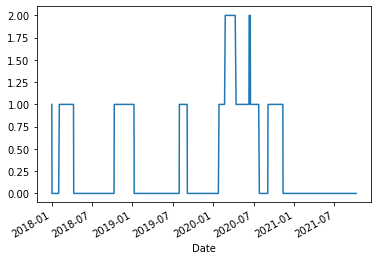

In [ ]:
testrets['State'].plot()

In [ ]:
testrets.groupby('State').mean()['Shifted_Return'] * np.sqrt(252)

State
0    0.015526
1    0.006685
2   -0.046941
Name: Shifted_Return, dtype: float64

In [ ]:
testrets.groupby('State').std()['Shifted_Return']

State
0    0.007017
1    0.014475
2    0.037721
Name: Shifted_Return, dtype: float64

In [ ]:
testrets.groupby('State').count()['Return']

State
0    645
1    266
2     38
Name: Return, dtype: int64

## Recommended readings 

- Market Regime Identification Using Hidden Markov Models https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3406068

- Regime-Switching Factor Investing with Hidden Markov Models https://www.mdpi.com/1911-8074/13/12/311/htm




## Lecture 3 Portfolio Optimisation 

Examples of portfolio construction 

- 60/40
- mean-variance portfolio optimisation
- Hierarchical Risk Parity (HRP) portfolio



In [3]:
! pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

In [4]:
selected_etf = yf.Ticker("TLT")
tlthist = selected_etf.history(period="max")
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")

In [5]:
tlthist['return'] = tlthist['Close'].loc['2005-01-01':].pct_change()
spyhist['return'] = spyhist['Close'].loc['2005-01-01':].pct_change()

In [6]:
# 60/40 portfolio 
classic = 0.6 * spyhist['return'] + 0.4 * tlthist['return']
classic = classic.dropna()

In [7]:
portfolio_classic = (1 + classic).cumprod()

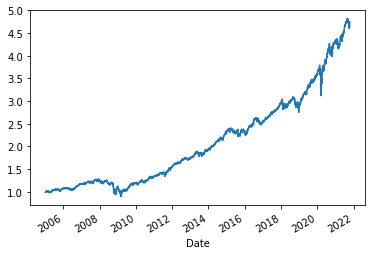

In [8]:
portfolio_classic.plot()

In [9]:
classic.mean() / classic.std()

0.05841693026086997

The sharpe ratio of 60/40 portfolio is better than the buy and hold portfolio and volatility-scaled portfolio of SPY. Over the last 20 years, bond is a successful hedge for stocks. 


In [10]:
! pip install PyPortfolioOpt

     |████████████████████████████████| 60 kB 3.4 MB/s 
     |████████████████████████████████| 2.7 MB 12.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [11]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

We will demonstrate a very basic example of Mean-variance optimization using different stocks and bonds ETF

In [12]:
prices = list()

ETF_list = ['SPY','QQQ','EWU','TLT','LQD','EEM']

for ETF in ETF_list :
    selected_etf = yf.Ticker(ETF)
    etfhist = selected_etf.history(period="max")
    prices.append(etfhist['Close'].loc['2005-01-01':])

In [37]:
merged_prices = pd.DataFrame(pd.concat(prices,axis=1))
merged_prices.columns = ETF_list

In [38]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(merged_prices)
S = CovarianceShrinkage(merged_prices).ledoit_wolf()

In [39]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [40]:
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('SPY', 0.0),
             ('QQQ', 0.4738),
             ('EWU', 0.0),
             ('TLT', 0.50163),
             ('LQD', 0.02457),
             ('EEM', 0.0)])

In [41]:
ef.portfolio_performance(verbose=True)

Expected annual return: 10.5%
Annual volatility: 10.1%
Sharpe Ratio: 0.84


(0.10512907871069763, 0.10120293736595166, 0.841172014631051)

Lets use a different portfolio optimisation method, Hierarchical Risk Parity (HRP) portfolio.

Risk Parity portfolio tends to overweights bonds (LQD,TLT).

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [ ]:
ef = HRPOpt(merged_prices.pct_change(), S)

In [ ]:
ef.optimize()

OrderedDict([('EEM', 0.036998581975009576),
             ('EWU', 0.03142927658589791),
             ('LQD', 0.563857499030923),
             ('QQQ', 0.12317205377822954),
             ('SPY', 0.046660406258609906),
             ('TLT', 0.19788218237132998)])

In [ ]:
ef.portfolio_performance()

(0.07584490584254756, 0.07950358115875131, 0.7024200045912079)

We can also change the optimisation criteria for Efficiet Frontier to penalise downside volatility only

In [ ]:
from pypfopt import expected_returns, EfficientSemivariance

In [ ]:
mu = expected_returns.mean_historical_return(merged_prices)
historical_returns = expected_returns.returns_from_prices(merged_prices)

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.1)

OrderedDict([('SPY', 1.706652184e-07),
             ('QQQ', 0.435253707289589),
             ('EWU', 4.434351885e-07),
             ('TLT', 0.4916306585473967),
             ('LQD', 0.0731146858689396),
             ('EEM', 3.339121142e-07)])

In [ ]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('SPY', 0.0), ('QQQ', 0.43525), ('EWU', 0.0), ('TLT', 0.49163), ('LQD', 0.07311), ('EEM', 0.0)])
Expected annual return: 10.0%
Annual semi-deviation: 6.6%
Sortino Ratio: 1.21


(0.10000007671486659, 0.06637534051334501, 1.205268042260096)

In [ ]:
target_portfolio = list()

for target_return in [0.05,0.1,0.15]:
    es = EfficientSemivariance(mu, historical_returns)
    es.efficient_return(target_return)
    weights = es.clean_weights()
    weights['Sortino'] = es.portfolio_performance()[-1]
    weights['Target'] = target_return
    target_portfolio.append(weights)

In [ ]:
pd.DataFrame(target_portfolio)

,SPY,QQQ,EWU,TLT,LQD,EEM,Sortino,Target
0,0.15307,0.04113,0.0,0.23180,0.57400,0.0,0.866360,0.05
1,0.00000,0.43525,0.0,0.49163,0.07311,0.0,1.205268,0.10
2,0.00000,0.99887,0.0,0.00113,0.00000,0.0,0.871827,0.15


There are other portfolio optimisation methods such as Black-Litterman which can incoporate our guess on portfolio returns 

We will demonstrate a very simple but effective way to construct portfolio which can be applied to both individual assets and alpha factors. 

We decide a lookback period (252 days) to calculate the rolling volatility of each asset. For a given risk level (15% p.a.), we scale the position we will take for each asset so that we will have equal risk in each asset, before taking into account of correlation between strategies.

We then take the simple average over these strategies to form our portfolio. 

We can then calculate the overall volatility of the portfolio, which will be lower than the given risk level due to negative correlation between strategies. We can then leverage the whole portfolio to the target risk level. 

While this method is different from risk parity, as it does not explicitly consider the correlation between assets. The two-step optimisation process is more robust than risk parity when correlation structure between stratgies/assets changes. 


In [48]:
merged_returns = merged_prices.pct_change().dropna()
merged_std = merged_returns.rolling(252).std() * np.sqrt(252)

In [49]:
merged_pos = 0.2 / merged_std 

In [50]:
merged_portfolio = merged_pos * merged_returns

In [51]:
portfolio = (1 + np.mean(merged_portfolio,axis=1)).cumprod()

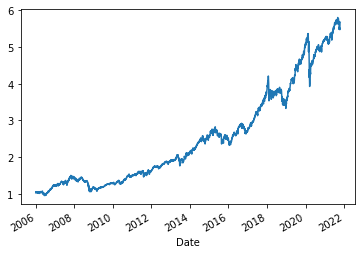

In [52]:
portfolio.plot()

In [53]:
average_return = np.mean(merged_portfolio,axis=1)

In [54]:
average_return.mean() / average_return.std() * np.sqrt(252)

0.878800126855252

In [55]:
average_return.mean() * 252, average_return.std() * np.sqrt(252)

(0.11926893019998172, 0.13571792556150442)

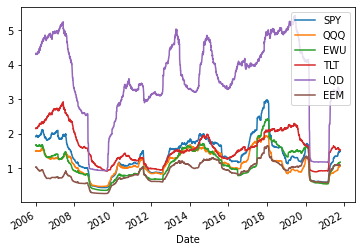

In [61]:
merged_pos.dropna().plot()

The sharpe ratio we obtained by averaging the return of vol-scaled ETF is better than the one we obtained by Mean-Variance optimisation. 

Taking a simple average of vol-scaled strategies can outperform more sophiscated portfolio optimisation methods unless one has a good understanding on the correlation structure of the strategies.

As above, we assume we can take leverage without incurring additional costs. For our example, we assume we can leverage on US Investment Crop Bonds (LQD) up to 5x, which is unlikely for retail to achieve. 



## Lecture 4 Technical Analysis

We will use Moving Averages, which is a very simple trend following strategy

In [ ]:
import pandas as pd

In [ ]:
prices = list()

ETF_list = ['SPY','QQQ','EWU','TLT','LQD','EEM',]

for ETF in ETF_list :
    selected_etf = yf.Ticker(ETF)
    etfhist = selected_etf.history(period="max")
    etfhist['Return'] = etfhist['Open'].pct_change()
    etfhist['Volatility'] = etfhist['Return'].rolling(126).std()
    etfhist['Return2'] = etfhist['Return'] / etfhist['Volatility'] * 0.01
    prices.append(etfhist['Return2'])

In [ ]:
merged_prices = pd.DataFrame(pd.concat(prices,axis=1)).dropna()
merged_prices.columns = ETF_list

In [ ]:
ticker = 'EEM'
stock = pd.DataFrame(merged_prices[ticker])

In [ ]:
stock['Shifted_Return'] = stock[ticker].shift(-1)

In [ ]:
stock['Portfolio_return'] = 0
count = 0
for MA_parm in range(25,50,5):
    count += 1
    col = ticker + 'price'
    stock[col] = (1+stock[ticker]).cumprod()
    stock['MA_{}'.format(MA_parm)] = stock[col].rolling(MA_parm).mean()
    stock['MA_return_{}'.format(MA_parm)] = np.where(stock['MA_{}'.format(MA_parm)]<stock[col],1,0) * stock['Shifted_Return']
    stock['Portfolio_return'] += stock['MA_return_{}'.format(MA_parm)]
stock['Portfolio_return'] = stock['Portfolio_return']/count

In [ ]:
stock['Portfolio_return'].loc['2015-01-01':].mean() / stock['Portfolio_return'].loc['2015-01-01':].std() * np.sqrt(252)

0.5452631186657061

In [ ]:
stock['Shifted_Return'].loc['2015-01-01':].mean() / stock['Shifted_Return'].loc['2015-01-01':].std() * np.sqrt(252)

0.35786256393434895